# Back to Convolutional Autoencoder

### Initial imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Input, Conv2D, Flatten, UpSampling2D, Dense, ZeroPadding2D
from keras.models import Model
from keras.callbacks import EarlyStopping

### Loading images

In [2]:
# Dataset dependant parameters
data_path = "data/3ball/"
num_systems = 10000
num_balls = 3
pix = 32

X1 = []
for i in tqdm(glob(data_path + "Input/image1_*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    X1.append(im)
X1 = np.array(X1, dtype="float32") / 255

X2 = []
for i in tqdm(glob(data_path + "Input/image2_*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    X2.append(im)
X2 = np.array(X2, dtype="float32") / 255

Y = []
for i in tqdm(glob(data_path + "Output/*.png")):
    im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    im = keras.utils.img_to_array(im)
    Y.append(im)
Y = np.array(Y, dtype="float32") / 255

100%|██████████| 10000/10000 [00:03<00:00, 2630.45it/s]


### Temperature computation and data split

In [3]:
coordinates = np.loadtxt(data_path + 'coordinates.csv', delimiter=',')
coordinates = coordinates[:, -2*num_balls:] / 4

temperature = np.zeros((num_systems))

for i in range(num_systems):
    for j in range(num_balls):
        # Add the speed of each ball to the temperature
        temperature[i] += np.sqrt(np.sum(np.square(coordinates[i, 2*j : 2*(j+1)])))
    
    # Divide by number of balls to get the mean
    temperature[i] /= num_balls

# Concatenate both frames
X = np.concatenate((X1, X2), axis=3)
# Train-val-test split (80-10-10)
x_train, x_test, y_train, y_test, temperature_train, temperature_test = train_test_split(X, Y, temperature, test_size=0.2)
x_val, x_test, y_val, y_test, temperature_val, temperature_test = train_test_split(x_test, y_test, temperature_test, test_size=0.5)

### Model definition and training

In [4]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, (3,3), activation="relu", padding="same")(x)
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, (3,3), activation="relu", padding="same")(x)
   return x

def downsample_block(x, n_filters):
   x = double_conv_block(x, n_filters)
   x = ZeroPadding2D(padding=(1, 1))(x)
   x = Conv2D(n_filters, (3,3), activation="relu", strides = (2,2))(x)
   return x

def upsample_block(x, n_filters):
   # upsample
   x = UpSampling2D(size=(2, 2), interpolation='nearest')(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x


# Input layer
inputs = Input(shape=(pix,pix,2))

# Encoder layer
u1 = downsample_block(inputs, 1)

# Bottleneck layer
bottleneck = double_conv_block(u1, 2)

# Decoder layer
u3 = upsample_block(bottleneck, 1)

# Output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(u3)

load_model = False

# Build or load model
if load_model:
   conv_autoencoder = keras.models.load_model("conv_autoencoder")
else:
   conv_autoencoder = Model(inputs, outputs, name="Convolutional_Autoencoder")

conv_autoencoder.summary()

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

Model: "Convolutional_Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 1)         19        
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 1)         10        
                                                                 
 zero_padding2d (ZeroPadding  (None, 34, 34, 1)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 1)         10        
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 2)         20        
                                         

In [5]:
conv_autoencoder.compile(optimizer='adam', loss='mse')

conv_autoencoder.fit(x_train, y_train,
                epochs=250,
                batch_size=32,
                shuffle=True,
                validation_data=(x_val, y_val),
                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)])

Epoch 1/250
250/250 [==============================] - 10s 24ms/step - loss: 0.2187 - val_loss: 0.1928
Epoch 2/250
250/250 [==============================] - 5s 22ms/step - loss: 0.1711 - val_loss: 0.1511
Epoch 3/250
250/250 [==============================] - 5s 21ms/step - loss: 0.1346 - val_loss: 0.1196
Epoch 4/250
250/250 [==============================] - 5s 21ms/step - loss: 0.1074 - val_loss: 0.0962
Epoch 5/250
250/250 [==============================] - 5s 21ms/step - loss: 0.0872 - val_loss: 0.0790
Epoch 6/250
250/250 [==============================] - 5s 21ms/step - loss: 0.0723 - val_loss: 0.0662
Epoch 7/250
250/250 [==============================] - 5s 21ms/step - loss: 0.0612 - val_loss: 0.0566
Epoch 8/250
250/250 [==============================] - 5s 21ms/step - loss: 0.0528 - val_loss: 0.0493
Epoch 9/250
250/250 [==============================] - 5s 21ms/step - loss: 0.0464 - val_loss: 0.0437
Epoch 10/250
250/250 [==============================] - 5s 21ms/step - loss: 0.04

### Model reconstructions

We print (from left to right) the 3 frames of the sample (2 inputs and output), an auxiliar image to see of how much movement there is between the first and final frame, the reconstructed image and the 3rd frame over the reconstructed image. This last image is useful to see if the position of the balls is accurately predicted.

32/32 [==============================] - 0s 9ms/step


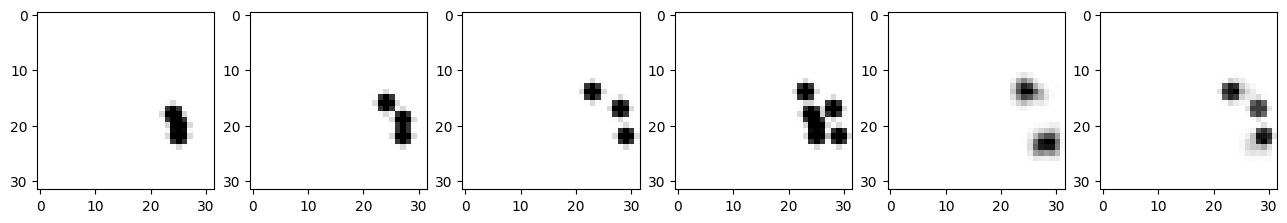

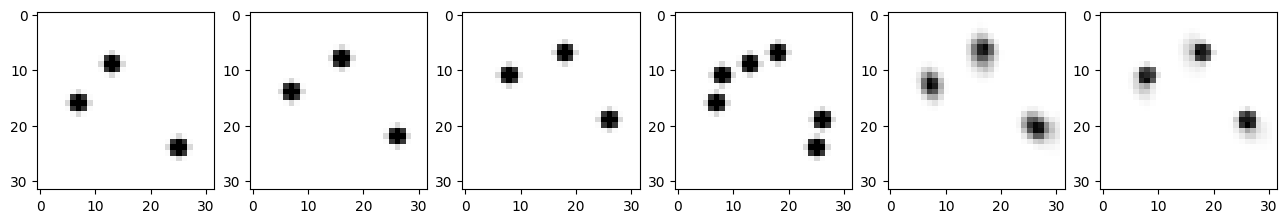

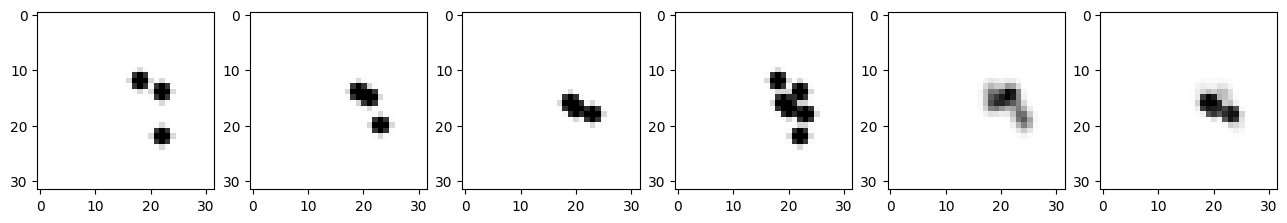

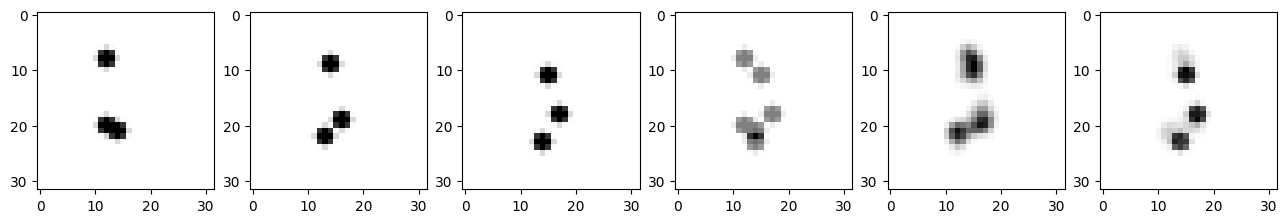

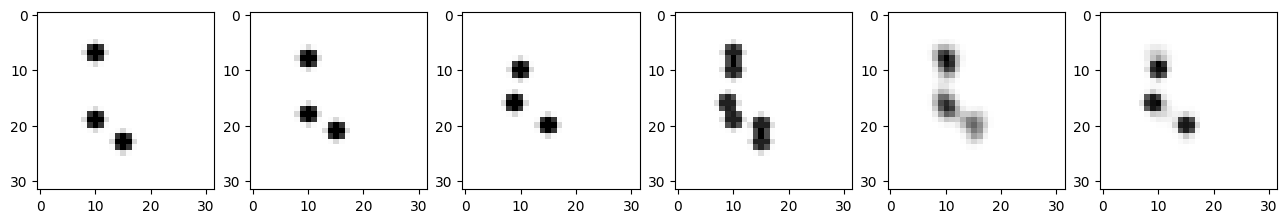

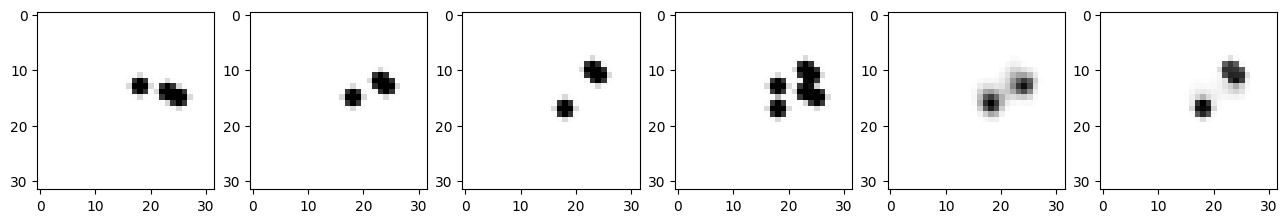

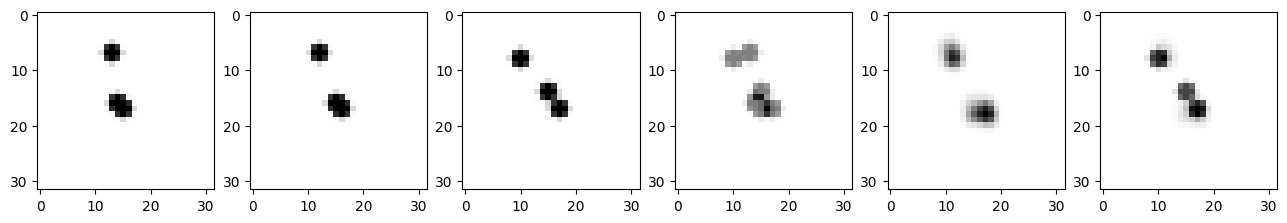

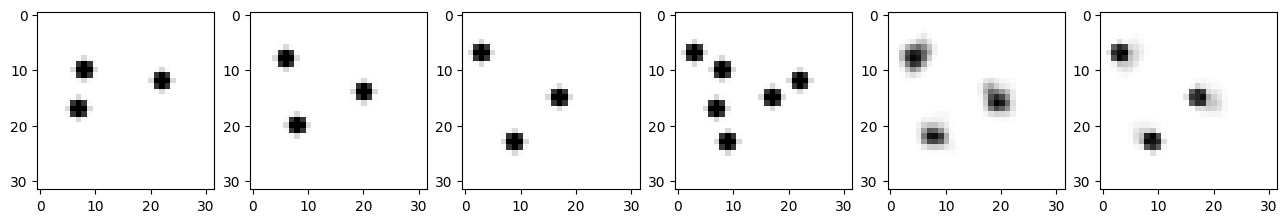

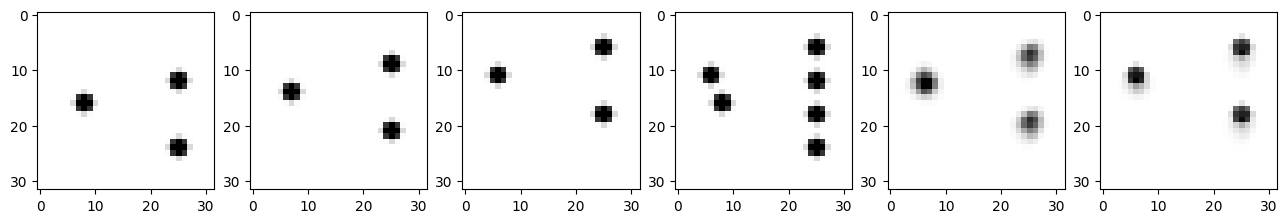

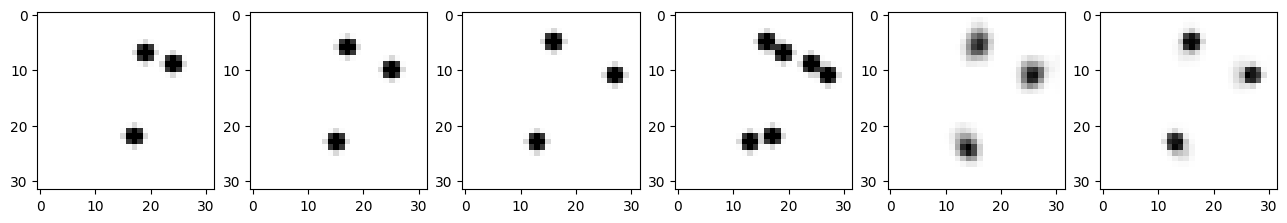

In [6]:
predictions = conv_autoencoder.predict(x_test)

for i in range(10):
    plt.figure(figsize=(16, 96))
    # First image
    plt.subplot(1, 6, 1)
    plt.imshow(x_test[i,:,:,0].reshape(pix, pix), cmap='gray')

    # Second image
    plt.subplot(1, 6, 2)
    plt.imshow(x_test[i,:,:,1].reshape(pix, pix), cmap='gray')

    # Third image
    plt.subplot(1, 6, 3)
    plt.imshow(y_test[i].reshape(pix, pix), cmap='gray')

    # Balls in first and final frame to check how much movement there is on that sample
    plt.subplot(1, 6, 4)
    plt.imshow(y_test[i].reshape(pix, pix) + x_test[i,:,:,0].reshape(pix, pix), cmap='gray')

    # Predicted image
    plt.subplot(1, 6, 5)
    plt.imshow(predictions[i].reshape(pix, pix), cmap='gray')

    # Image to predict over reconstruction
    plt.subplot(1, 6, 6)
    plt.imshow(y_test[i].reshape(pix, pix) + predictions[i].reshape(pix, pix)/2, cmap='gray')

    plt.show()

### Temperature regression

We will try to regress the temperature of the system with the activation weights of the bottleneck layer.

In [7]:
last_layer = Model(inputs=conv_autoencoder.input, outputs=conv_autoencoder.get_layer('conv2d_4').output)

# Get the encoded representation of the images in train, validation and test sets
encoded_imgs_train = last_layer.predict(x_train)
encoded_imgs_val = last_layer.predict(x_val)
encoded_imgs_test = last_layer.predict(x_test)

# Reshape to vectors (flatten)
encoded_imgs_train_flat = encoded_imgs_train.reshape((encoded_imgs_train.shape[0], -1))
encoded_imgs_val_flat = encoded_imgs_val.reshape((encoded_imgs_val.shape[0], -1))
encoded_imgs_test_flat = encoded_imgs_test.reshape((encoded_imgs_test.shape[0], -1))

32/32 [==============================] - 0s 6ms/step


### Investigating the activation layers

We have a look at the activation layers to try to understand what is happening inside the neural network.

1/1 [==============================] - 0s 118ms/step
input_1


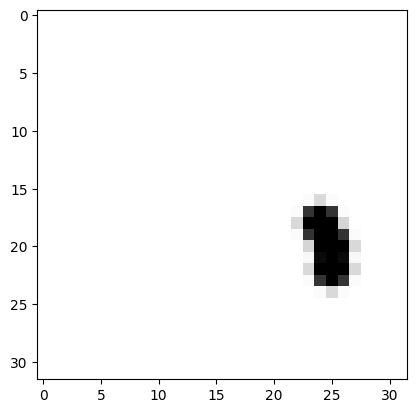

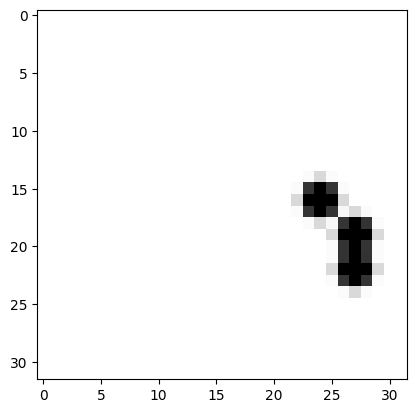

conv2d


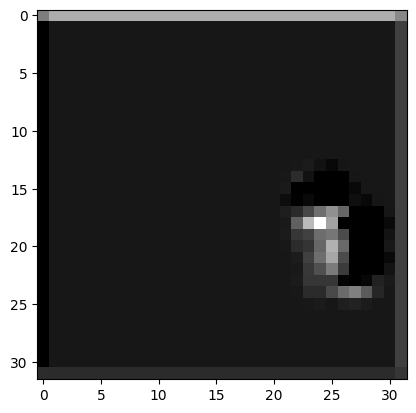

conv2d_1


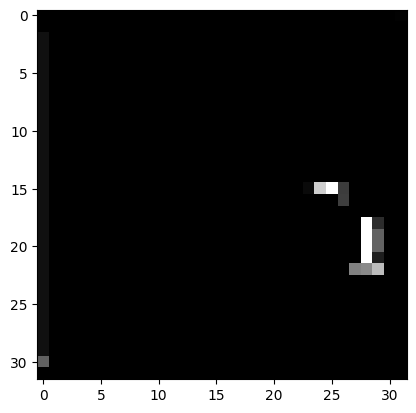

zero_padding2d


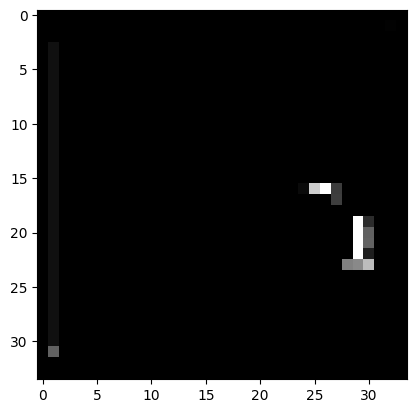

conv2d_2


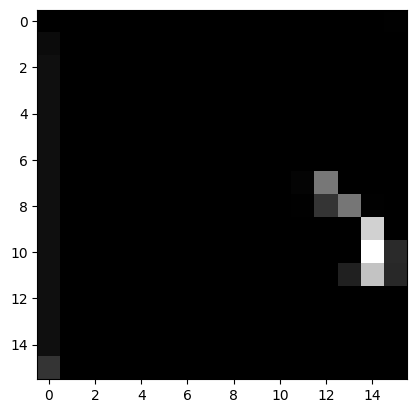

conv2d_3


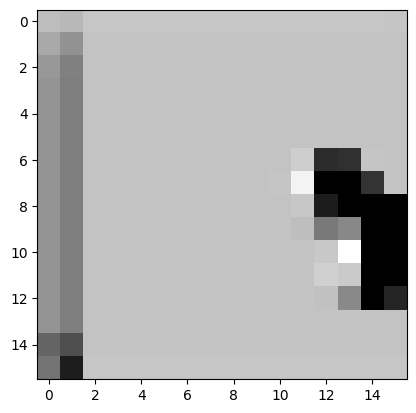

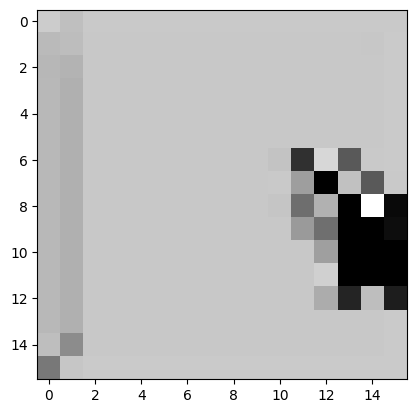

conv2d_4


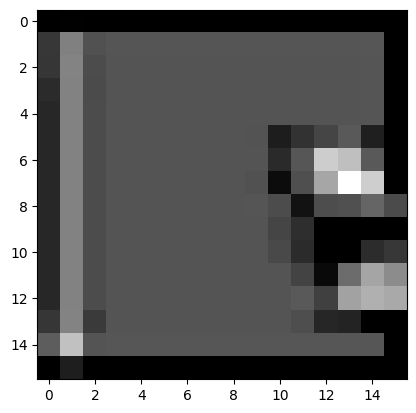

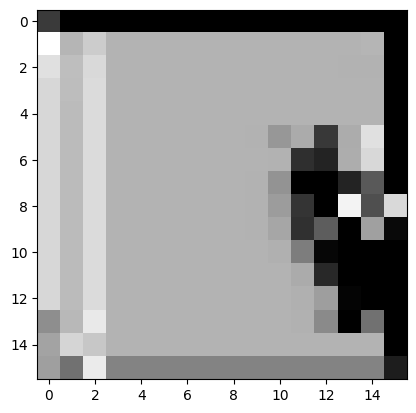

up_sampling2d


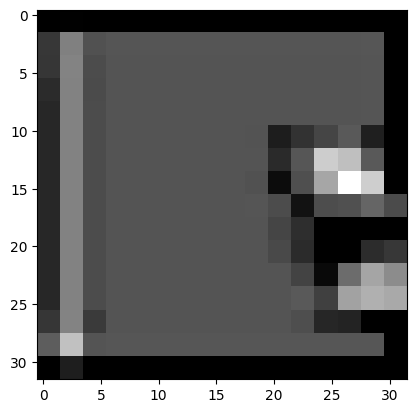

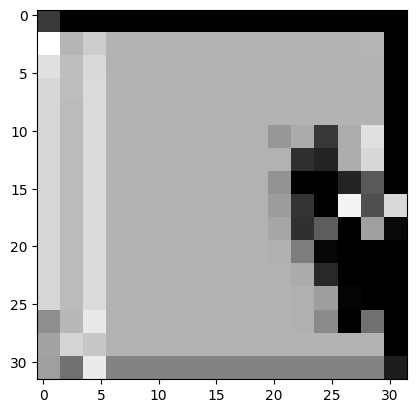

conv2d_5


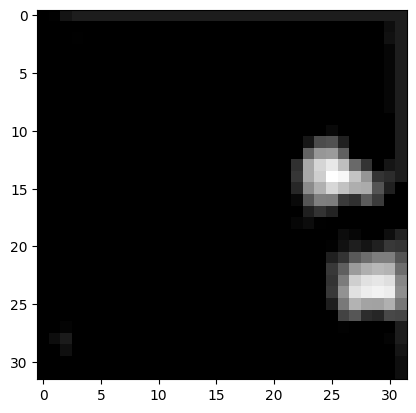

conv2d_6


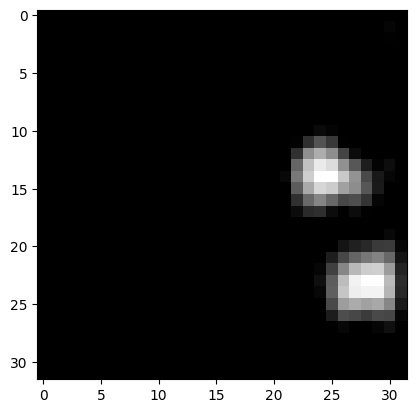

conv2d_7


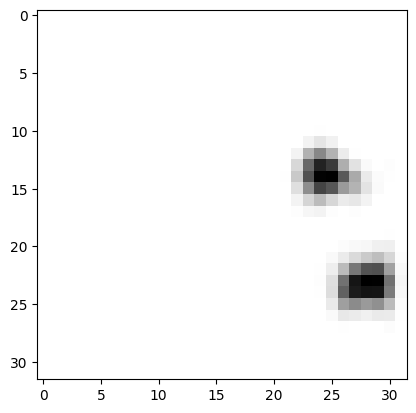

In [8]:
# Get all the layers of the model
layers = conv_autoencoder.layers

outputs = [layer.output for layer in layers]
layer_outputs = Model(inputs=conv_autoencoder.input, outputs=outputs)

layer_outputs = layer_outputs.predict(x_test[0].reshape(1, pix, pix, 2))

# Print the output of each layer
for i, output in enumerate(layer_outputs):
    if layers[i].name in ['dense', 'reshape', 'flatten', 'dense_1']:
        continue
    print(layers[i].name)
    for j in range(output.shape[3]):
        plt.imshow(output[:,:,:,j].reshape(output.shape[1], output.shape[2]), cmap='gray')
        plt.show()
        plt.close()

### Temperature regressor

In [9]:
inputs = Input(shape=(16,16,2))

x = Conv2D(12, (16,16), activation="relu")(inputs)
x = Flatten()(x)
x = Dense(12)(x)

outputs = Dense(1)(x)

temperature_regressor = Model(inputs, outputs, name="temperature_regressor")

temperature_regressor.summary()

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

Model: "temperature_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 2)]       0         
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 12)          6156      
                                                                 
 flatten (Flatten)           (None, 12)                0         
                                                                 
 dense (Dense)               (None, 12)                156       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 6,325
Trainable params: 6,325
Non-trainable params: 0
_________________________________________________________________


In [10]:
temperature_regressor.compile(optimizer='adam', loss='mse')

temperature_regressor.fit(encoded_imgs_train, temperature_train,
                             epochs=100,
                             batch_size=32,
                             shuffle=True,
                             validation_data=(encoded_imgs_val, temperature_val),
                             callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)])

Epoch 1/100
250/250 [==============================] - 1s 2ms/step - loss: 0.0341 - val_loss: 0.0344
Epoch 2/100
250/250 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0301
Epoch 3/100
250/250 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0342
Epoch 4/100
250/250 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0318
Epoch 5/100
250/250 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0304
Epoch 6/100
250/250 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0270
Epoch 7/100
250/250 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0271
Epoch 8/100
250/250 [==============================] - 0s 2ms/step - loss: 0.0265 - val_loss: 0.0279
Epoch 9/100
250/250 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0282
Epoch 10/100
250/250 [==============================] - 1s 2ms/step - loss: 0.0253 - val_lo

In [11]:
temperature_predictions = temperature_regressor.predict(encoded_imgs_test)

for i in range(5):
    print('Sample ' + str(i) + '\nPrediction: ' + str(temperature_predictions[i]) + '\nActual temperature: ' + str(temperature_test[i]))

32/32 [==============================] - 0s 967us/step
Sample 0
Prediction: [0.57763016]
Actual temperature: 0.6030056647916492
Sample 1
Prediction: [0.4184045]
Actual temperature: 0.7171292729553325
Sample 2
Prediction: [0.38435575]
Actual temperature: 0.5393446629166316
Sample 3
Prediction: [0.4282613]
Actual temperature: 0.5590169943749475
Sample 4
Prediction: [0.40064308]
Actual temperature: 0.4166666666666667
